In [1]:
import torch
import numpy as np
from pathlib import Path
from PIL import Image
import os
import sys

PROJECTDIR = os.path.normpath(os.path.join(os.getcwd(), "../"))
GAN_DIR = os.path.join(PROJECTDIR, "ganspace")
sys.path.insert(0, GAN_DIR)
sys.path.insert(0, PROJECTDIR)

from ganspace.config import Config
from ganspace.models import get_instrumented_model
from ganspace.decomposition import get_or_compute

StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


In [2]:
torch.autograd.set_grad_enabled(False)

model_name = 'StyleGAN2'
class_name = 'car'
layer_name = 'style'

# model_name = 'BigGAN-512'
# class_name = 'car'
# layer_name = 'generator.gen_z'

use_w = 'StyleGAN' in model_name
device = torch.device('cpu')

In [3]:
inst = get_instrumented_model(model_name, class_name, layer_name, device, use_w=use_w)
model = inst.model

pc_config = Config(
    components=80,
    n=1_000_000,
    batch_size=200,
    layer=layer_name,
    model=model_name,
    output_class=class_name,
    use_w=use_w)

dump_name = get_or_compute(pc_config, inst)

with np.load(dump_name) as data:
    lat_comp = data['lat_comp']
    lat_mean = data['lat_mean']
    lat_std = data['lat_stdev']

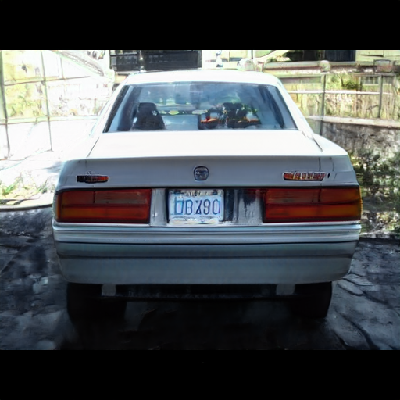

In [7]:
seed = None
w = model.sample_latent(1, seed=seed).cpu().numpy()

# # w = np.zeros(w.shape, dtype=w.dtype)

# w_list = [w] * model.get_max_latents()

img = model.sample_np(w)

Image.fromarray((img * 255).astype(np.uint8)).resize((400, 400))

Normal


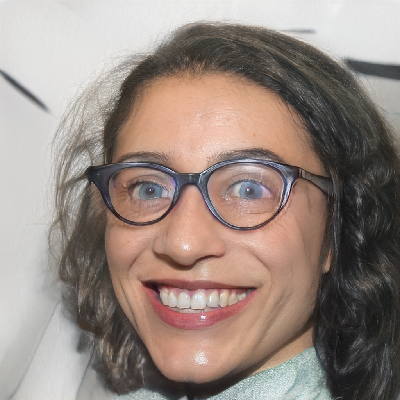

In [14]:
# for l in range(start, end):
#     w[l] = w[l] + lat_comp[idx] * strength

unit_direction = False
norm_sample = True

if unit_direction:
    print("Unit")
    xi_vector = np.zeros((1, 80), dtype=np.dtype("float32"))
    xi_vector[0][0] = 1
    lat_add = np.matmul(xi_vector, lat_comp[:,0,:], dtype=w.dtype)
elif norm_sample:
    print("Normal")
    comp_weights = np.expand_dims(np.random.normal(scale=1, size=80), axis=0)
    lat_add = np.matmul(comp_weights, lat_comp[:,0,:], dtype=w.dtype)
else:
    print("Constatnt")
    c = 2.5
    comp_weights = np.ones((1,80)) * c
    lat_add = np.matmul(comp_weights, lat_comp[:,0,:], dtype=w.dtype)

w_list = [w + lat_add] * model.get_max_latents()

mod_img = model.sample_np(w_list)

Image.fromarray((mod_img * 255).astype(np.uint8)).resize((400, 400))

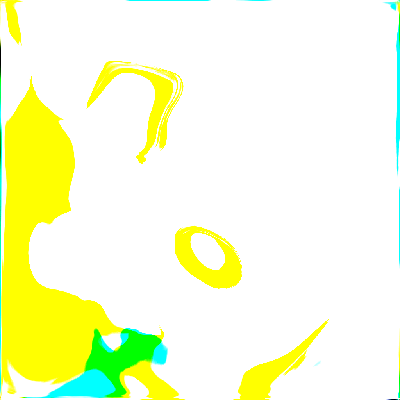

In [38]:
comp_weights = np.expand_dims(np.random.normal(scale=1, size=80), axis=0)
lat_add = np.matmul(comp_weights, lat_comp[:,0,:], dtype=w.dtype)

w_list = [lat_add] * model.get_max_latents()

mod_img = model.sample_np(w_list)

Image.fromarray((mod_img * 255).astype(np.uint8)).resize((400, 400))